In [20]:
import numpy as np
import matplotlib.pyplot as plt
from pytransform3d.plot_utils import make_3d_axis
from pytransform3d.rotations import active_matrix_from_intrinsic_euler_xyz
from pytransform3d.transformations import transform_from, plot_transform
from pytransform3d.camera import make_world_grid, world2image, plot_camera
import numpy as np
import matplotlib.pyplot as plt
from pytransform3d import rotations as pr
from pytransform3d import transformations as pt
from pytransform3d.transform_manager import TransformManager
import cv2


In [21]:
class Point():
    def __init__(self):
        self.x=0
        self.y=0
        self.z=0

class Quaternion():
    def __init__(self):
        self.x=0
        self.y=0
        self.z=0
        self.w=0

class Pose():
    def __init__(self):
        self.position=Point()
        self.orientation=Quaternion()

In [22]:
def get_coordinates_from_pose(pose : Pose, camera_matrix=None, marker_len=None) -> np.array:
    """
    This function receives the pose of a marker with respect to the camera
    and returns the coordinates of 4 corner points in the image plane
    If the optional args are not given they will be read from the ROS Params
    """
    # corner points in the marker coordinate system
    hl = marker_len/2
    # corners_in_marker=np.array([[-hl, -hl, 0, 1], [+hl, hl, 0, 1], [hl, hl, 0, 1], [-hl, hl, 0, 1]])
    # corners_in_marker=np.array([[+hl, +hl, 0, 1], [-hl, +hl, 0, 1], [-hl, -hl, 0, 1], [+hl, -hl, 0, 1]])
    corners_in_marker=np.array([[-hl, -hl, 0, 1], [+hl, -hl, 0, 1],[+hl, +hl, 0, 1], [-hl, +hl, 0, 1]]) 
    #print('corners_in_marker: \n'+str(corners_in_marker))

    # Create a pytransform corresponding to the passed pose
    marker2cam_pose_array = np.array([pose.position.x, pose.position.y, pose.position.z, 
              pose.orientation.x, pose.orientation.y, pose.orientation.z, pose.orientation.w]) # vector and quaternion concat
    marker2cam = pt.transform_from_pq(marker2cam_pose_array)

    corners_in_cam = pt.transform(A2B=marker2cam, PA=corners_in_marker) # transform points into camera frame
    #print('corners_in_cam: \n'+str(corners_in_cam))
    corners_in_cam_T = np.transpose(corners_in_cam)

    camera_mat_Homog = np.append(camera_matrix, np.zeros((3,1)), axis=1)
    corners_in_img_Homog = np.matmul(camera_mat_Homog, corners_in_cam_T)

    corners_in_img = np.transpose(np.array([np.divide(corners_in_img_Homog[0,:],corners_in_img_Homog[2,:]), # divide with scale for each
                                            np.divide(corners_in_img_Homog[1,:],corners_in_img_Homog[2,:])]))
    #print('corners_in_img: \n'+str(corners_in_img))                                      
    return corners_in_img

In [23]:
from scipy.spatial.transform import Rotation
import io
from PIL import Image
def get_pose_from_coordinates(coordinates: np.array, camera_matrix=None, marker_len=None, camera_distortion=None) -> Pose:
    """
    This function receives the coordinates of 4 corner points and returns their pose estimation respect to the camera
    If the optional args are not given they will be read from the ROS Params
    """
    # initiate geometry_msgs objects
    trans = Point()
    rot = Quaternion()
    pose = Pose()

    try: # importing parameters from ROS if not given as args
        if (np.array(camera_matrix) == None).any():
            _camera_matrix_dict= rospy.get_param("camera_matrix")
            _camera_matrix = np.array(_camera_matrix_dict['data'])
            camera_matrix = np.reshape(_camera_matrix, (_camera_matrix_dict['rows'], _camera_matrix_dict['cols']))
        
        if marker_len == None:
            _marker_len = rospy.get_param("aruco_marker_length")
            marker_len = float(_marker_len)
        
        if (np.array(camera_distortion) == None).any():
            _camera_distortion_dict= rospy.get_param("distortion_coefficients")
            _camera_distortion = np.array(_camera_distortion_dict['data'])
            camera_distortion = np.reshape(_camera_distortion, (_camera_distortion_dict['rows'], _camera_distortion_dict['cols']))
    except:
        # rospy.logerr("utils.get_pose_from_coordinates: Could not read ROS Params")
        return pose # empty pose
   

    # Use the built-in pose estimation of opencv to estimate the pose of the aruco marker found by detect_markers
    rvecs, tvecs, _objPoints = cv2.aruco.estimatePoseSingleMarkers(np.array(coordinates).astype(np.float32), 
                                                                   np.float32(marker_len), 
                                                                   np.array(camera_matrix).astype(np.float32), 
                                                                   np.array(camera_distortion).astype(np.float32))

    
    # create Point representing translation of estimated pose
    [trans.x, trans.y, trans.z] = tvecs[0][0]

    # create Quaternion representing rotation of estimated pose
    _r = Rotation.from_rotvec(rvecs[0][0]) # Rotation object from SciPy
    [rot.x, rot.y, rot.z, rot.w] = Rotation.as_quat(_r)

    # compose and publish Pose object
    pose.position=trans
    pose.orientation=rot

    return pose

In [24]:
###################
## PCP
###################

# Define Pose
pose_pcp_1 = Pose()
pose_pcp_1.position.z = 0.8
[pose_pcp_1.orientation.x, pose_pcp_1.orientation.y, pose_pcp_1.orientation.z, pose_pcp_1.orientation.w] = pr.quaternion_from_axis_angle([1,0,0,0.45*np.pi])

camera_matrix = np.eye(3)
marker_len=0.4
camera_distortion = np.zeros((1,5))

# get coordinates of corners from projection
coordinates_pcp = get_coordinates_from_pose(pose_pcp_1, camera_matrix, marker_len)
valid_coordinates_for_testing = coordinates_pcp
print('valid coordinates for testing: \n'+str(valid_coordinates_for_testing)+'\n')

# get back pose from the above coordinates
pose_pcp_2=get_pose_from_coordinates(np.array([coordinates_pcp]), camera_matrix, marker_len, camera_distortion)

marker2camera =  pt.transform_from_pq([pose_pcp_1.position.x, pose_pcp_1.position.y, pose_pcp_1.position.z, 
pose_pcp_1.orientation.x, pose_pcp_1.orientation.y, pose_pcp_1.orientation.z, pose_pcp_1.orientation.w])

marker2camera_2 =  pt.transform_from_pq([pose_pcp_2.position.x, pose_pcp_2.position.y, pose_pcp_2.position.z, 
pose_pcp_2.orientation.x, pose_pcp_2.orientation.y, pose_pcp_2.orientation.z, pose_pcp_2.orientation.w])

tm_pcp = TransformManager()
tm_pcp.add_transform("marker", "pose orig", marker2camera)
tm_pcp.add_transform("marker", "pose copy", marker2camera_2)


valid coordinates for testing: 
[[-0.33197096 -0.0519317 ]
 [ 0.33197096 -0.0519317 ]
 [ 0.20049368  0.03136412]
 [-0.20049368  0.03136412]]



In [25]:
###################
## CPC
###################

# Define Pose
   ###  coordinates_cpc_1 = np.array([[-0.25, -0.25], [0.25, -0.25], [0.25, 0.25], [-0.25, 0.25]])
coordinates_cpc_1 = valid_coordinates_for_testing

camera_matrix = np.eye(3)
marker_len=0.4
camera_distortion = np.zeros((1,5))


pose_cpc=get_pose_from_coordinates(np.array([coordinates_cpc_1]), camera_matrix, marker_len, camera_distortion)
# get coordinates of corners from projection
coordinates_cpc_2 = get_coordinates_from_pose(pose_cpc, camera_matrix, marker_len)

print('coordinates_cpc_1: \n'+str(coordinates_cpc_1)+'\n')
print('coordinates_cpc_2: \n'+str(coordinates_cpc_2)+'\n')

marker2camera_3 =  pt.transform_from_pq([pose_cpc.position.x, pose_cpc.position.y, pose_cpc.position.z, 
pose_cpc.orientation.x, pose_cpc.orientation.y, pose_cpc.orientation.z, pose_cpc.orientation.w])

tm_cpc = TransformManager()
tm_cpc.add_transform("marker", "pose", marker2camera_3)

coordinates_cpc_1: 
[[-0.33197096 -0.0519317 ]
 [ 0.33197096 -0.0519317 ]
 [ 0.20049368  0.03136412]
 [-0.20049368  0.03136412]]

coordinates_cpc_2: 
[[-0.2860307   0.20781346]
 [-0.20781346 -0.2860307 ]
 [ 0.2860307  -0.20781347]
 [ 0.20781346  0.28603069]]



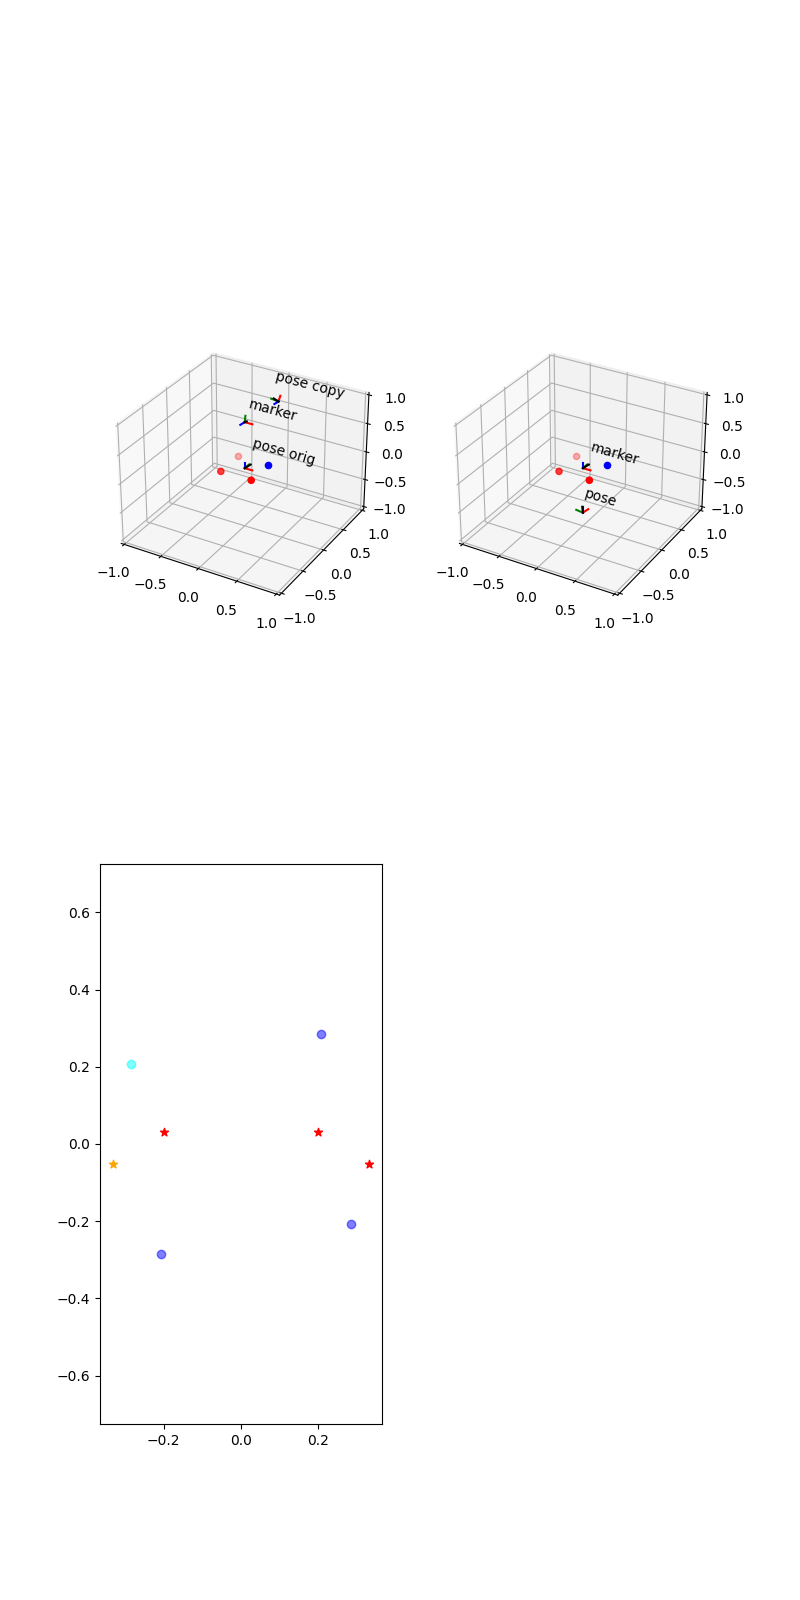

In [26]:
%matplotlib widget
fig = plt.figure(figsize=(8,16), facecolor='#FFFFFF')
ax_pose_coor_pose = fig.add_subplot(2,2,1, projection='3d')
ax_coor_pose_coor = fig.add_subplot(2,2,2, projection='3d')
ax_coordinates = fig.add_subplot(2,2,3)

testpoints=np.array([[0.2, 0.2, 0, 1], [-0.2, 0.2, 0, 1], [0.2, -0.2, 0, 1], [-0.2, -0.2, 0, 1]])

tm_pcp.plot_frames_in("pose orig", ax=ax_pose_coor_pose, s=0.1)
ax_pose_coor_pose.scatter(testpoints[1:,0],testpoints[1:,1],testpoints[1:,2], color="r")
ax_pose_coor_pose.scatter(testpoints[0,0],testpoints[0,1],testpoints[0,2], color="b") # corner one marked blue
ax_pose_coor_pose.set_xlim((-1, 1))
ax_pose_coor_pose.set_ylim((-1, 1))
ax_pose_coor_pose.set_zlim((-1, 1))

tm_cpc.plot_frames_in("marker", ax=ax_coor_pose_coor, s=0.1)
ax_coor_pose_coor.scatter(testpoints[1:,0],testpoints[1:,1],testpoints[1:,2], color="r")
ax_coor_pose_coor.scatter(testpoints[0,0],testpoints[0,1],testpoints[0,2], color="b") # corner one marked blue
ax_coor_pose_coor.set_xlim((-1, 1))
ax_coor_pose_coor.set_ylim((-1, 1))
ax_coor_pose_coor.set_zlim((-1, 1))

ax_coordinates.scatter(coordinates_cpc_1[1:,0], coordinates_cpc_1[1:,1], color = 'red', marker='*')
ax_coordinates.scatter(coordinates_cpc_1[0,0], coordinates_cpc_1[0,1], color = 'orange', marker='*')
ax_coordinates.scatter(coordinates_cpc_2[1:,0], coordinates_cpc_2[1:,1], color = 'blue', alpha=0.5)
ax_coordinates.scatter(coordinates_cpc_2[0,0], coordinates_cpc_2[0,1], color = 'cyan', alpha=0.5)
ax_coordinates.set_aspect(1,adjustable='datalim') # equal aspect ratio of axes

plt.show(fig)